### **Introducción a la Inteligencia Artificial en Medicina**
Taller dictado por iHEALTH

Recuerda ejecutar **TODAS** las celdas en orden

<a target="_blank" href="https://colab.research.google.com/github/iHealthInstitute/tutorials/blob/main/taller-2023-07-13-SUMA/TallerIntroIAEnMedicina.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Preparar el ambiente

Descargamos librerías y datos

In [1]:
!pip install -q "monai-weekly[pillow, tqdm]"
!pip install -q matplotlib
!pip install -q gdown
%matplotlib inline
import monai
import matplotlib
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
import numpy as np
from sklearn.metrics import classification_report

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
)
from monai.utils import set_determinism

print_config()

_dummy_arr = torch.rand(1, device='cuda')

directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(f"Root dir: {root_dir}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.8 MB/s eta 0:00:00
MONAI version: 1.3.dev2329
Numpy version: 1.22.4
Pytorch version: 2.0.1+cu118
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c82c65a288e396f8f7d059e82373edb1814b20be
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.0.2
scikit-image version: 0.19.3
Pillow version: 8.4.0
Tensorboard version: 2.12.3
gdown version: 4.6.6
TorchVision version: 0.15.2+cu118
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 1.5.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the o

In [3]:
!gdown 1Ig45opmPavH_WgJiGBVV446LbqFfUAEd
!unzip -q -o /content/BDCerebro.zip
!gdown 170rGaBqXh5mWagnmEMkbkLGZPdE0JS3a

Downloading...
From: https://drive.google.com/uc?id=1Ig45opmPavH_WgJiGBVV446LbqFfUAEd
To: /content/BDCerebro.zip
100% 139M/139M [00:08<00:00, 17.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=170rGaBqXh5mWagnmEMkbkLGZPdE0JS3a
To: /content/mejor_metrica_model.pth
100% 28.4M/28.4M [00:00<00:00, 32.5MB/s]


## Leer nombres de archivos de la carpeta de la base de datos

Primero verificaremos las estadísticas de la base de datos.

Tenemos 4 carpetas en la base de datos: glioma, meningioma, pituitaria y notumor.

Estos nombres de las carpetas serán las clases para clasificar

In [4]:
carpetaBD="BDCerebro"
nombres_clases = sorted(x for x in os.listdir(carpetaBD) if os.path.isdir(os.path.join(carpetaBD, x)))
cantidad_clases = len(nombres_clases)
archivos_imagenes = [
    [os.path.join(carpetaBD, nombres_clases[i], x) for x in os.listdir(os.path.join(carpetaBD, nombres_clases[i]))]
    for i in range(cantidad_clases)
]
conteo_clase = [len(archivos_imagenes[i]) for i in range(cantidad_clases)]
lista_archivos_imagenes = []
clase_imagen = []
for i in range(cantidad_clases):
    lista_archivos_imagenes.extend(archivos_imagenes[i])
    clase_imagen.extend([i] * conteo_clase[i])
num_total = len(clase_imagen)
image_width, image_height = PIL.Image.open(lista_archivos_imagenes[0]).size

print(f"Cantidad total de imágenes: {num_total}")
print(f"Dimensiones imágenes: {image_width} x {image_height}")
print(f"Nombres de las clases: {nombres_clases}")
print(f"Imágenes por clase: {conteo_clase}")

Cantidad total de imágenes: 7023
Dimensiones imágenes: 450 x 450
Nombres de las clases: ['glioma', 'meningioma', 'notumor', 'pituitary']
Imágenes por clase: [1621, 1645, 2000, 1757]


## Elegiremos algunas imágenes al azar para mostrarlas



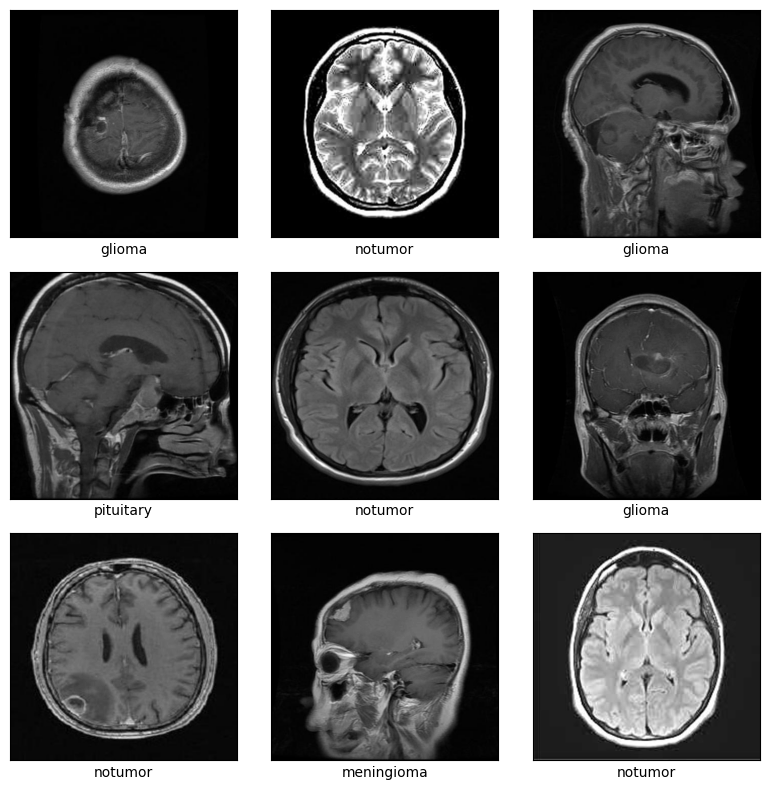

In [5]:
plt.subplots(3, 3, figsize=(8, 8))
for i, k in enumerate(np.random.randint(num_total, size=9)):
    im = PIL.Image.open(lista_archivos_imagenes[k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(nombres_clases[clase_imagen[k]])
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

## Preparación de la lista de entrenamiento, validación y testeo

Elegimos aleatoreamente el 10% de la base de datos para validación y otro 10% para testeo. El 80% restante se usará para entrenar.

In [7]:
fraccion_validacion = 0.1
fraccion_testeo = 0.1
conteo_imagenes = len(lista_archivos_imagenes)
indices = np.arange(conteo_imagenes)
np.random.shuffle(indices)

test_split = int(fraccion_testeo * conteo_imagenes)
val_split = int(fraccion_validacion * conteo_imagenes) + test_split
test_indices = indices[:test_split]
val_indices = indices[test_split:val_split]
train_indices = indices[val_split:]

train_x = [lista_archivos_imagenes[i] for i in train_indices]
train_y = [clase_imagen[i] for i in train_indices]
val_x = [lista_archivos_imagenes[i] for i in val_indices]
val_y = [clase_imagen[i] for i in val_indices]
test_x = [lista_archivos_imagenes[i] for i in test_indices]
test_y = [clase_imagen[i] for i in test_indices]

print(f"Imágenes de entrenamiento: {len(train_x)}, Imágenes de validación: " f"{len(val_x)}, Imágenes de testeo: {len(test_x)}")

Imágenes de entrenamiento: 5619, Imágenes de validación: 702, Imágenes de testeo: 702


## Agregamos transformaciones a las imágenes y preparamos los datos

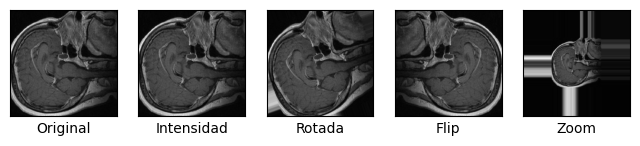

In [8]:
train_transforms = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        ScaleIntensity(),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
    ]
)

val_transforms = Compose([LoadImage(image_only=True), EnsureChannelFirst(), ScaleIntensity()])

y_pred_trans = Compose([Activations(softmax=True)])
y_trans = Compose([AsDiscrete(to_onehot=cantidad_clases)])

class MedNISTDataset(torch.utils.data.Dataset):
    def __init__(self, archivos_imagenes, labels, transforms):
        self.archivos_imagenes = archivos_imagenes
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.archivos_imagenes)

    def __getitem__(self, index):
        return self.transforms(self.archivos_imagenes[index]), self.labels[index]


train_ds = MedNISTDataset(train_x, train_y, train_transforms)
train_loader = DataLoader(train_ds, batch_size=20, shuffle=True, num_workers=2)

val_ds = MedNISTDataset(val_x, val_y, val_transforms)
val_loader = DataLoader(val_ds, batch_size=20, num_workers=2)

test_ds = MedNISTDataset(test_x, test_y, val_transforms)
test_loader = DataLoader(test_ds, batch_size=20, num_workers=2)
plt.subplots(1, 5, figsize=(8, 8))
image, _ = train_ds[np.random.randint(len(train_ds))]

def plot_subplot(image, plot_idx, title):
  plt.subplot(1, 5, plot_idx)
  plt.imshow(image.squeeze(0), cmap="gray")
  plt.xlabel(title)
  plt.xticks([])
  plt.yticks([])

plot_subplot(image, 1, "Original")
plot_subplot(ScaleIntensity(minv=0.1, maxv=20)(image), 2, "Intensidad")
plot_subplot(RandRotate(range_x=np.pi / 2, prob=1, keep_size=True)(image), 3, "Rotada")
plot_subplot(RandFlip(spatial_axis=1, prob=1)(image), 4, "Flip")
plot_subplot(RandZoom(min_zoom=0.4, max_zoom=1.6, prob=1)(image), 5, "Zoom")
plt.show()

## Definimos la red y el optimizador

1. Fijamos el learning rate que define qué tanto se modifica nuestro modelo por batch.
1. Fijamos la cantidad de épocas de entrenamiento, así como las transformaciones que requiere la imagen


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNet121(spatial_dims=2, in_channels=1, out_channels=cantidad_clases).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
max_epocas = 4
val_interval = 1
auc_metric = ROCAUCMetric()

## Entrenamiento del modelo


In [ ]:
set_determinism(seed=0)

In [ ]:
assert root_dir and os and torch, "Recuerda correr todas las celdas anteriores"

mejor_metrica = -1
mejor_metrica_epoca = -1
epoca_loss_values = []
metric_values = []

for epoca in range(max_epocas):
    print("-" * 10)
    print(f"epoca {epoca + 1}/{max_epocas}")
    model.train()
    epoca_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoca_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"función de pérdida: {loss.item():.4f}")
        epoca_len = len(train_ds) // train_loader.batch_size
    epoca_loss /= step
    epoca_loss_values.append(epoca_loss)
    print(f"epoca {epoca + 1} pérdida promedio: {epoca_loss:.4f}")

    if (epoca + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data[0].to(device),
                    val_data[1].to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > mejor_metrica:
                mejor_metrica = result
                mejor_metrica_epoca = epoca + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "mejor_metrica_model.pth"))
                print("mejor modelo guardado")
            print(
                f"epoca actual: {epoca + 1}"
                f" acierto actual: {acc_metric:.4f}"
            )

print(f"train completed, mejor_metrica: {mejor_metrica:.4f} " f"at epoca: {mejor_metrica_epoca}")

----------
epoca 1/4
1/280, función de pérdida: 1.3418
2/280, función de pérdida: 1.3606
3/280, función de pérdida: 1.3763
4/280, función de pérdida: 1.2638
5/280, función de pérdida: 1.3216
6/280, función de pérdida: 1.3497
7/280, función de pérdida: 1.2739
8/280, función de pérdida: 1.2360
9/280, función de pérdida: 1.3068
10/280, función de pérdida: 1.2798
11/280, función de pérdida: 1.2117
12/280, función de pérdida: 1.3017
13/280, función de pérdida: 1.2615
14/280, función de pérdida: 1.2755
15/280, función de pérdida: 1.3275
16/280, función de pérdida: 1.2068
17/280, función de pérdida: 1.0916
18/280, función de pérdida: 1.2445
19/280, función de pérdida: 1.0736
20/280, función de pérdida: 1.2751
21/280, función de pérdida: 1.0646
22/280, función de pérdida: 1.1004
23/280, función de pérdida: 1.1887
24/280, función de pérdida: 1.1532
25/280, función de pérdida: 1.0893
26/280, función de pérdida: 1.2033
27/280, función de pérdida: 1.1307
28/280, función de pérdida: 1.1573
29/280, 

## Dibujamos la función de pérdida y las métricas

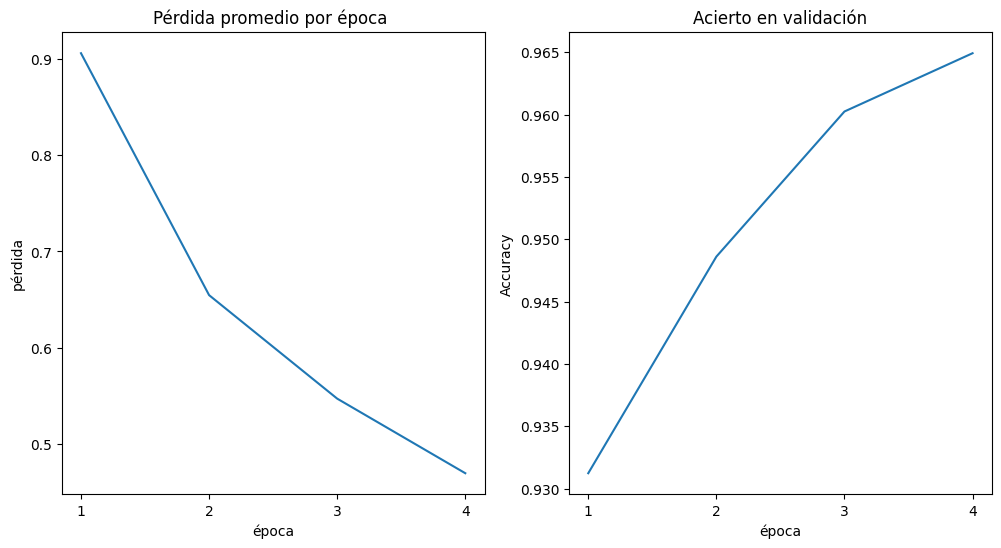

In [ ]:
plt.figure("entrenamiento", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Pérdida promedio por época ")
x = [i + 1 for i in range(len(epoca_loss_values))]
y = epoca_loss_values
plt.xlabel("época")
plt.ylabel("pérdida")
plt.xticks(np.arange(len(epoca_loss_values)) + 1)
plt.plot(x, y)

plt.subplot(1, 2, 2)
plt.title("Acierto en validación")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("época")
plt.xticks(np.arange(len(metric_values)) + 1)
plt.ylabel("Accuracy")
plt.plot(x, y)
plt.show()

## Evaluación de los resultados



In [ ]:
model_path_dir = os.path.join(root_dir, "mejor_metrica_model.pth")
# model_path_dir = '/content/mejor_metrica_model.pth'

model.load_state_dict(torch.load(model_path_dir))
_ = model.eval()

<ipython-input-16-201a7250b9cb>:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, n_test_samples, i + 1)


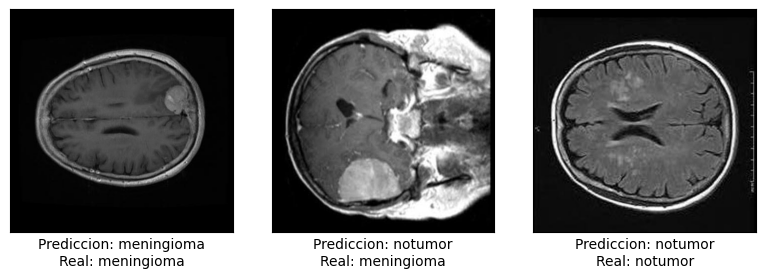

In [ ]:
n_test_samples = 3

images, labels = tuple(zip(*[
    test_ds[idx]
    for idx in np.random.randint(len(test_ds), size=3)
]))
images = torch.stack(images).to(device)
labels = np.array(labels)

with torch.no_grad():
  preds = model(images.cuda()).argmax(dim=1)

images = images.squeeze(1).cpu().numpy()
preds = preds.cpu().numpy()
plt.subplots(1, n_test_samples, figsize=(8, 8))
for i, (image, pred, label) in enumerate(zip(images, preds, labels)):
    plt.subplot(3, n_test_samples, i + 1)
    plt.xlabel(f"Prediccion: {nombres_clases[pred]}\nReal: {nombres_clases[label]}")
    plt.imshow(image, cmap="gray")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [ ]:
y_true = []
y_pred = []
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

In [ ]:
print(classification_report(y_true, y_pred, target_names=nombres_clases, digits=4))

              precision    recall  f1-score   support

      glioma     0.8940    0.8544    0.8738       158
  meningioma     0.8217    0.6463    0.7235       164
     notumor     0.9309    0.9619    0.9461       210
   pituitary     0.8098    0.9765    0.8853       170

    accuracy                         0.8675       702
   macro avg     0.8641    0.8598    0.8572       702
weighted avg     0.8677    0.8675    0.8631       702



Este tutorial fue realizado en base a
# Medical Image Classification Tutorial with the MedNIST Dataset

Copyright (c) MONAI Consortium  





